In [78]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
testdate='202004'
# testdate='2020Q3'
look_back = 3
PARTNO ='85-ECT0010'

# look_back = 3 # 87
# PARTNO ='85-EKA0190'

# look_back = 1
# PARTNO ='85-EKA0270'
# look_back = 2
# PARTNO ='85-EMA0130'

# look_back = 2
# PARTNO ='87-WPT1070'

# look_back = 11 #.5022385511111256
# PARTNO ='86-DIA0120'

#array(['85-ECT0010', '85-EKA0190', '85-EKA0270', '85-EMA0130',
    #    '87-WPT1070', '86-DIA0120', '85-EMA0900', '85-EMA0910',
    #    '85-EMA0920'], dtype=object)

In [79]:
def fillMissTime():
    df = pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
    # df['MFG_MONTH'] = pd.to_datetime(df['MFG_MONTH'].values, format='%Y%m').astype('period[Q]')
    df['MFG_MONTH'] = pd.to_datetime(df['MFG_MONTH'].values, format='%Y%m').astype('period[M]')
    df=df[df['PART_NO']==PARTNO] 
    df =df.groupby(['MFG_MONTH']).sum()
    

    df = df.sort_values(by=['MFG_MONTH'], ascending=[True])
    df.reindex(pd.period_range(df.index[0],df.index[-1],freq='M'))

    df = df.reset_index()
    df.drop(columns=['PM','TS','ENG','NST'],inplace=True)
    return df[df['MFG_MONTH']<=testdate]  ,df[df['MFG_MONTH']>testdate]     


In [80]:
def accsum(def_result,target_cols):
        _accsum=0 
        for index,row in def_result.iterrows():
            #避免當分母為0 會無法計算
            if row[target_cols]==0 and row['Predict']==0 :
                row[target_cols] =1
                row['Predict'] =1
            elif row[target_cols] ==0 and row['Predict']!=0:
                row[target_cols]  =0.00001

            if row[target_cols] <0 :
                row[target_cols]  =0.00001

            if row['Predict'] <0 :
                row['Predict']  =0 

            if 1- abs((row['Predict'] - row[target_cols])/row[target_cols] ) >0 : 
                _accsum+=(1- abs((row['Predict'] - row[target_cols])/row[target_cols] ))
        
        return round(_accsum*100/def_result.shape[0],2)

(23, 2) (2, 2)
20
Train on 20 samples
Epoch 1/100
20/20 [==============================] - 3s 167ms/sample - loss: 0.4172
Epoch 2/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.1275
Epoch 3/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.0230
Epoch 4/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.0223
Epoch 5/100
20/20 [==============================] - 0s 7ms/sample - loss: 0.0209
Epoch 6/100
20/20 [==============================] - 0s 7ms/sample - loss: 0.0197
Epoch 7/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.0184
Epoch 8/100
20/20 [==============================] - 0s 7ms/sample - loss: 0.0174
Epoch 9/100
20/20 [==============================] - 0s 7ms/sample - loss: 0.0163
Epoch 10/100
20/20 [==============================] - 0s 7ms/sample - loss: 0.0162
Epoch 11/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.0147
Epoch 12/100
20/20 [==============================] - 0s

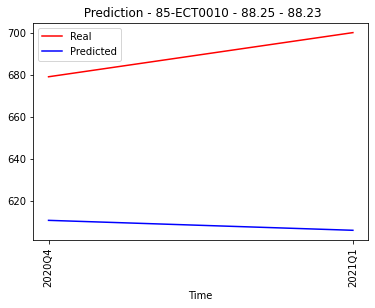

In [81]:

#Importing the Training Dataset
# train = pd.read_csv('./LSTMDATA/Google_Stock_Price_Train.csv') # 1258
train ,test = fillMissTime() # 72 ,3
print(train.shape,test.shape)
training_set = train.iloc[:, 1:2].values # 72

#Featuring Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
scaled_training_data = sc.fit_transform(training_set)

#Creating Data Structure with 60 Time Stamps and 1 output
x_train = []
y_train = []

for i in range(look_back,train.shape[0]):
    x_train.append(scaled_training_data[i-look_back:i, 0])
    y_train.append(scaled_training_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(len(x_train))



#Building the RNN
#Importing the tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#Initilizing RNN
LSTMmodel = Sequential()

#Adding first LSTM Layer and Dropout Regularization
# LSTMmodel.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
LSTMmodel.add(LSTM(units = 50, input_shape = (x_train.shape[1], 1)))
# LSTMmodel.add(Dropout(rate = 0.2))

# #Adding Second LSTM Layer and Dropout Regularization
# LSTMmodel.add(LSTM(units = 50, return_sequences = True))
# LSTMmodel.add(Dropout(rate = 0.2))

# #Adding Third LSTM Layer and Dropout Regularization
# LSTMmodel.add(LSTM(units = 50, return_sequences = True))
# LSTMmodel.add(Dropout(rate = 0.2))

# #Adding fourth LSTM Layer and Dropout Regularization
# LSTMmodel.add(LSTM(units = 50))
# LSTMmodel.add(Dropout(rate = 0.2))

#Adding the output Layer
LSTMmodel.add(Dense(units = 1))

#Compiling the RNN
LSTMmodel.compile(optimizer = 'adam', loss = 'mean_squared_error' )

# # ----------------
# # 无状态
# if STATELESS:
#     # stateless
#     model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
#             validation_data=(Xtest, Ytest),
#             shuffle=False)

# # 有状态
# else:
#     # 将训练和测试数据设为BATCH_SIZE的倍数
#     train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
#     test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE
#     Xtrain, Ytrain = Xtrain[0:train_size], Ytrain[0:train_size]
#     Xtest, Ytest = Xtest[0:test_size], Ytest[0:test_size]
#     print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
#     for i in range(NUM_EPOCHS):
#         print("Epoch {:d}/{:d}".format(i+1, NUM_EPOCHS))
#         model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=1,
#                 validation_data=(Xtest, Ytest),
#                 shuffle=False)
#         model.reset_states()

# model_score, _ = LSTMmodel.evaluate(Xtest, Ytest, batch_size=1)
# rmse = math.sqrt(model_score)
# print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))


# ------------------
#Fitting the RNN to the Training Set
# early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history_lstm_model = LSTMmodel.fit(x_train, y_train, epochs = 100, batch_size = 1,verbose = 1 ,shuffle=True)



# lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

#Making the predictions and visulization

#Getting the real stock price of google
# test = pd.read_csv('./LSTMDATA/Google_Stock_Price_Test.csv')
# real_stock_price = test.iloc[:, 1:2].values
real_test_price = test['QTY'].iloc[:].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['QTY'], test['QTY']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(look_back, inputs.shape[0]):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
testPredict = LSTMmodel.predict(X_test)
testPredict = sc.inverse_transform(testPredict)



test['Predict']=testPredict
_score_month = accsum(test,'QTY')
# Visualising the results
t = test['MFG_MONTH'].astype(str).to_numpy() 
plt.plot(t,real_test_price, color = 'red', label = 'Real')
plt.plot(t,testPredict, color = 'blue', label = 'Predicted')
_score =round((1- abs(testPredict.sum() -real_test_price.sum())/real_test_price.sum())*100,2)
plt.title(' Prediction - {0} - {1} - {2}'.format(PARTNO,_score_month,_score))
plt.xlabel('Time')
plt.xticks(rotation=90)    
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


#-----------------------------
trainPredict = LSTMmodel.predict(x_train)
trainPredict = sc.inverse_transform(trainPredict)
# train['Predict']=trainPredict
# _score_month_train = accsum(train,'QTY')
# print("train acc:",_score_month_train)
# print("test acc:",_score_month)




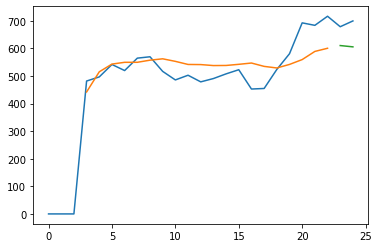

In [82]:
#-----------------------------

# 畫訓練資料趨勢圖
# shift train predictions for plotting

dataset_total = dataset_total.values.reshape(-1,1)
trainPredictPlot = np.empty_like(dataset_total, dtype=float)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# trainPredictPlot
# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_total, dtype=float)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset_total), :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(inputs))
plt.plot(dataset_total)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
#------------------------
